In [1]:
from pyspark.sql import SparkSession

# Path to your JDBC driver
jdbc_path = "/Users/joshuaflood/Repos/smart-store-joshua/lib/sqlite-jdbc.jar"

# Create Spark session
spark = (
    SparkSession.builder
    .appName("SmartStoreOLAP")
    .config("spark.driver.extraClassPath", jdbc_path)
    .getOrCreate()
)

spark

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/29 16:05:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
dw_path = "/Users/joshuaflood/Repos/smart-store-joshua/data_warehouse/datawarehouse.db"

# Load sales
sales_df = spark.read.format("jdbc").options(
    url=f"jdbc:sqlite:{dw_path}",
    dbtable="sale"
).load()

# Load customer
customer_df = spark.read.format("jdbc").options(
    url=f"jdbc:sqlite:{dw_path}",
    dbtable="customer"
).load()

# Load product
product_df = spark.read.format("jdbc").options(
    url=f"jdbc:sqlite:{dw_path}",
    dbtable="product"
).load()

sales_df.show(5)
customer_df.show(5)
product_df.show(5)

+-------+-----------+----------+---------------+---------+------------+
|sale_id|customer_id|product_id|sale_amount_usd|sale_date|payment_type|
+-------+-----------+----------+---------------+---------+------------+
|      1|       1034|      2059|         2048.2|   5/4/25|      Credit|
|      2|       1066|      2048|         321.87|   5/4/25|      Credit|
|      3|       1116|      2041|        3216.84|   5/4/25|      Credit|
|      4|       1071|      2096|        1613.23|   5/4/25|    GiftCard|
|      5|       1020|      2060|         408.38|   5/4/25|      PayPal|
+-------+-----------+----------+---------------+---------+------------+
only showing top 5 rows
+-----------+-------------+-------+---------+-----------------+------------------+
|customer_id|         name| region|join_date|open_invoices_num|retention_category|
+-----------+-------------+-------+---------+-----------------+------------------+
|       1000| Robert Gomez|   West|  2/25/24|                8|         Recover

In [3]:
sales_df.createOrReplaceTempView("sale")
customer_df.createOrReplaceTempView("customer")
product_df.createOrReplaceTempView("product")

In [4]:
slice_df = spark.sql("""
    SELECT *
    FROM sale
    WHERE payment_type = 'Credit'
""")

slice_df.show(10)

+-------+-----------+----------+---------------+---------+------------+
|sale_id|customer_id|product_id|sale_amount_usd|sale_date|payment_type|
+-------+-----------+----------+---------------+---------+------------+
|      1|       1034|      2059|         2048.2|   5/4/25|      Credit|
|      2|       1066|      2048|         321.87|   5/4/25|      Credit|
|      3|       1116|      2041|        3216.84|   5/4/25|      Credit|
|     10|       1119|      2089|         661.63|   5/4/25|      Credit|
|     11|       1042|      2077|         505.65|   5/4/25|      Credit|
|     15|       1026|      2089|         413.52|   5/4/25|      Credit|
|     16|       1144|      2005|        1715.12|   5/4/25|      Credit|
|     19|       1110|      2046|          30.09|   5/4/25|      Credit|
|     20|       1111|      2022|         671.18|   5/4/25|      Credit|
|     23|       1062|      2096|         672.18|   5/4/25|      Credit|
+-------+-----------+----------+---------------+---------+------

In [5]:
dice_df = spark.sql("""
    SELECT 
        c.region,
        p.category,
        SUM(c.open_invoices_num) AS total_open_invoices
    FROM sale s
    JOIN customer c 
        ON s.customer_id = c.customer_id
    JOIN product p 
        ON s.product_id = p.product_id
    GROUP BY c.region, p.category
    ORDER BY c.region, total_open_invoices DESC
""")

dice_df.show()

25/11/29 16:10:33 ERROR Executor: Exception in task 0.0 in stage 12.0 (TID 9)
org.apache.spark.SparkNumberFormatException: [CAST_INVALID_INPUT] The value 'A' of the type "STRING" cannot be cast to "DOUBLE" because it is malformed. Correct the value as per the syntax, or change its target type. Use `try_cast` to tolerate malformed input and return NULL instead. SQLSTATE: 22018
== SQL (line 5, position 9) ==
        SUM(c.open_invoices_num) AS total_open_invoices
        ^^^^^^^^^^^^^^^^^^^^^^^^

	at org.apache.spark.sql.errors.QueryExecutionErrors$.invalidInputInCastToNumberError(QueryExecutionErrors.scala:145)
	at org.apache.spark.sql.errors.QueryExecutionErrors.invalidInputInCastToNumberError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage4.hashAgg_doAggregate_sum_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage4.hashAgg_doConsume_0$(Unknown Source)

NumberFormatException: [CAST_INVALID_INPUT] The value 'A' of the type "STRING" cannot be cast to "DOUBLE" because it is malformed. Correct the value as per the syntax, or change its target type. Use `try_cast` to tolerate malformed input and return NULL instead. SQLSTATE: 22018
== SQL (line 5, position 9) ==
        SUM(c.open_invoices_num) AS total_open_invoices
        ^^^^^^^^^^^^^^^^^^^^^^^^


In [6]:
dice_df = spark.sql("""
    SELECT 
        c.region,
        p.category,
        SUM(TRY_CAST(c.open_invoices_num AS DOUBLE)) AS total_open_invoices
    FROM sale s
    JOIN customer c 
        ON s.customer_id = c.customer_id
    JOIN product p 
        ON s.product_id = p.product_id
    GROUP BY c.region, p.category
    ORDER BY c.region, total_open_invoices DESC
""")

dice_df.show()

+-------+-----------+-------------------+
| region|   category|total_open_invoices|
+-------+-----------+-------------------+
|Central|   Clothing|              224.0|
|Central|     Office|              219.0|
|Central|       Home|              214.0|
|Central|Electronics|              187.0|
|   EAST|       Home|              264.0|
|   EAST|   Clothing|              230.0|
|   EAST|     Office|              216.0|
|   EAST|Electronics|              161.0|
|   East|       Home|              267.0|
|   East|   Clothing|              201.0|
|   East|Electronics|              185.0|
|   East|     Office|              148.0|
|  North|       Home|              422.0|
|  North|   Clothing|              336.0|
|  North|     Office|              314.0|
|  North|Electronics|              290.0|
|  South|       Home|              298.0|
|  South|   Clothing|              296.0|
|  South|     Office|              208.0|
|  South|Electronics|              116.0|
+-------+-----------+-------------

In [7]:
clean_customer_df = spark.sql("""
    SELECT *
    FROM customer
    WHERE open_invoices_num RLIKE '^[0-9]+$'
""")

clean_customer_df.createOrReplaceTempView("customer_clean")

clean_customer_df.show(10)

+-----------+----------------+-------+---------+-----------------+------------------+
|customer_id|            name| region|join_date|open_invoices_num|retention_category|
+-----------+----------------+-------+---------+-----------------+------------------+
|       1000|    Robert Gomez|   West|  2/25/24|                8|         Recovered|
|       1001|      John Silva|   East|  12/1/20|                0|         Recovered|
|       1002|   Mark Marshall|Central|   8/8/20|                6|               New|
|       1003|   David Brennan|  North|  5/21/20|                2|         Recovered|
|       1004|   Kerry Collins|  North|  9/12/23|                4|         Recovered|
|       1005|    Jessica Mora|  South|   8/5/21|                3|            AtRisk|
|       1006|      Hannah Ray|   West|   7/3/21|                8|         Recovered|
|       1007|       David Kim|   West|  5/20/20|                3|            AtRisk|
|       1008| William Ramirez|   EAST|  9/15/23|      

In [8]:
dice_df = spark.sql("""
    SELECT 
        c.region,
        p.category,
        SUM(CAST(c.open_invoices_num AS DOUBLE)) AS total_open_invoices
    FROM sale s
    JOIN customer_clean c 
        ON s.customer_id = c.customer_id
    JOIN product p 
        ON s.product_id = p.product_id
    GROUP BY c.region, p.category
    ORDER BY c.region, total_open_invoices DESC
""")

dice_df.show()

+-------+-----------+-------------------+
| region|   category|total_open_invoices|
+-------+-----------+-------------------+
|Central|   Clothing|              224.0|
|Central|     Office|              219.0|
|Central|       Home|              214.0|
|Central|Electronics|              187.0|
|   EAST|       Home|              264.0|
|   EAST|   Clothing|              230.0|
|   EAST|     Office|              216.0|
|   EAST|Electronics|              161.0|
|   East|       Home|              267.0|
|   East|   Clothing|              201.0|
|   East|Electronics|              185.0|
|   East|     Office|              148.0|
|  North|       Home|              422.0|
|  North|   Clothing|              336.0|
|  North|     Office|              314.0|
|  North|Electronics|              290.0|
|  South|       Home|              298.0|
|  South|   Clothing|              296.0|
|  South|     Office|              208.0|
|  South|Electronics|              116.0|
+-------+-----------+-------------

In [9]:
drill_df = spark.sql("""
    SELECT
        c.region,
        p.category,
        c.name AS customer_name,
        CAST(c.open_invoices_num AS DOUBLE) AS open_invoices
    FROM sale s
    JOIN customer_clean c 
        ON s.customer_id = c.customer_id
    JOIN product p 
        ON s.product_id = p.product_id
    ORDER BY 
        c.region,
        p.category,
        open_invoices DESC
""")

drill_df.show(20)

+-------+--------+---------------+-------------+
| region|category|  customer_name|open_invoices|
+-------+--------+---------------+-------------+
|Central|Clothing|    Tyler Colon|          8.0|
|Central|Clothing|    Tyler Colon|          8.0|
|Central|Clothing|Sharon Bautista|          8.0|
|Central|Clothing|Sharon Bautista|          8.0|
|Central|Clothing|  Heather Olson|          7.0|
|Central|Clothing|  Heather Olson|          7.0|
|Central|Clothing|  Heather Olson|          7.0|
|Central|Clothing|  Matthew Clark|          7.0|
|Central|Clothing|  Matthew Clark|          7.0|
|Central|Clothing|  Matthew Clark|          7.0|
|Central|Clothing|    Louis Jones|          6.0|
|Central|Clothing|  Connor Martin|          6.0|
|Central|Clothing|  Connor Martin|          6.0|
|Central|Clothing|  Connor Martin|          6.0|
|Central|Clothing|    Louis Jones|          6.0|
|Central|Clothing|    Louis Jones|          6.0|
|Central|Clothing|    Louis Jones|          6.0|
|Central|Clothing|  

In [10]:
drill_df = spark.sql("""
    SELECT
        c.region,
        p.category,
        c.name AS customer_name,
        SUM(CAST(c.open_invoices_num AS DOUBLE)) AS total_open_invoices
    FROM sale s
    JOIN customer_clean c 
        ON s.customer_id = c.customer_id
    JOIN product p 
        ON s.product_id = p.product_id
    GROUP BY 
        c.region,
        p.category,
        c.name
    ORDER BY 
        c.region,
        p.category,
        total_open_invoices DESC
""")

drill_df.show(20)

+-------+--------+--------------------+-------------------+
| region|category|       customer_name|total_open_invoices|
+-------+--------+--------------------+-------------------+
|Central|Clothing|         Louis Jones|               30.0|
|Central|Clothing|       Mark Marshall|               24.0|
|Central|Clothing|       Matthew Clark|               21.0|
|Central|Clothing|       Heather Olson|               21.0|
|Central|Clothing|      Melissa Rivera|               18.0|
|Central|Clothing|       Connor Martin|               18.0|
|Central|Clothing|         Tyler Colon|               16.0|
|Central|Clothing|     Sharon Bautista|               16.0|
|Central|Clothing|       Taylor Clarke|               14.0|
|Central|Clothing|        Daniel Adams|               12.0|
|Central|Clothing|       Steven Wright|                9.0|
|Central|Clothing|         Casey Brown|                5.0|
|Central|Clothing|      Steven Jackson|                5.0|
|Central|Clothing|           Angel Lee| 

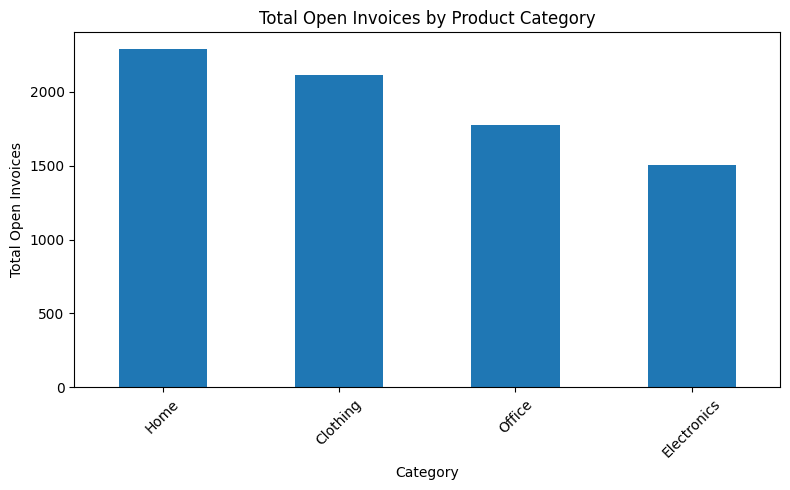

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert dice_df to pandas for plotting
dice_pd = dice_df.toPandas()

# Aggregate by category only
cat_totals = dice_pd.groupby("category")["total_open_invoices"].sum()

plt.figure(figsize=(8,5))
cat_totals.sort_values(ascending=False).plot(kind="bar")

plt.title("Total Open Invoices by Product Category")
plt.xlabel("Category")
plt.ylabel("Total Open Invoices")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

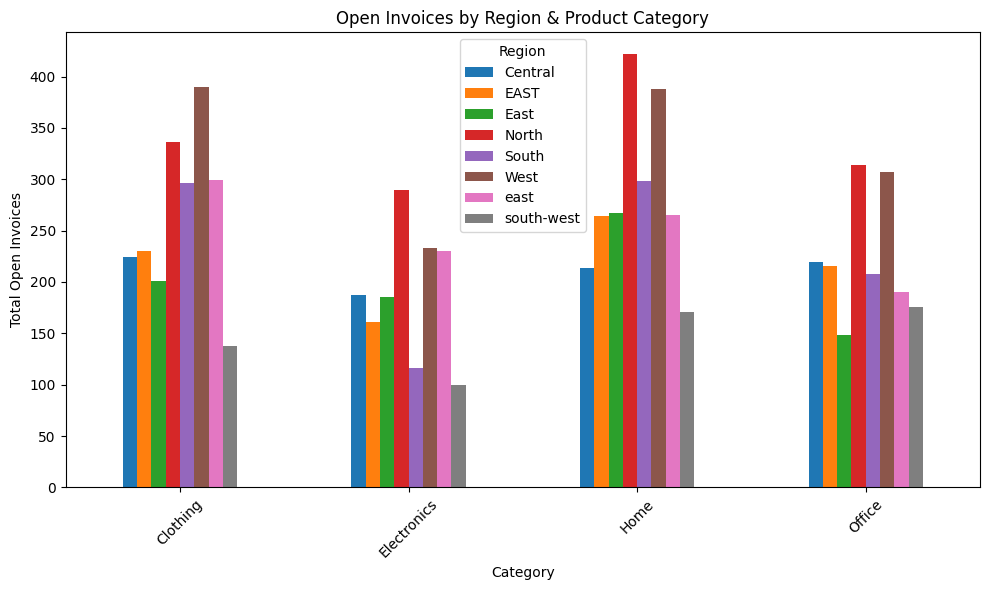

In [12]:
plt.figure(figsize=(10,6))

pivot_df = dice_pd.pivot(index="category",
                         columns="region",
                         values="total_open_invoices")

pivot_df.plot(kind="bar", figsize=(10,6))

plt.title("Open Invoices by Region & Product Category")
plt.xlabel("Category")
plt.ylabel("Total Open Invoices")
plt.xticks(rotation=45)
plt.legend(title="Region")
plt.tight_layout()
plt.show()

In [13]:
drill_pd = drilldown_fixed_df.toPandas()

# Aggregate to avoid duplicates
cust_totals = (drill_pd.groupby(["category", "customer_name"])["open_invoices"]
               .sum()
               .reset_index())

# Optional: choose a single category (example: Clothing)
cat = "Clothing"
cat_df = cust_totals[cust_totals["category"] == cat].sort_values(
    "open_invoices", ascending=False
)

plt.figure(figsize=(10,6))
plt.barh(cat_df["customer_name"], cat_df["open_invoices"])
plt.title(f"Top Customers with Open Invoices — {cat} Category")
plt.xlabel("Open Invoices")
plt.ylabel("Customer")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

NameError: name 'drilldown_fixed_df' is not defined

In [14]:
import matplotlib.pyplot as plt

# ------------------------------------------------------
# 1. Identify the correct drilldown dataframe
# ------------------------------------------------------
if "drilldown_clean_df" in globals():
    drill_pd = drilldown_clean_df.toPandas()
elif "drilldown_df" in globals():
    drill_pd = drilldown_df.toPandas()
else:
    raise NameError("No drilldown dataframe found. Make sure you ran the drilldown SQL first.")

# ------------------------------------------------------
# 2. Aggregate to avoid duplicates
# ------------------------------------------------------
cust_totals = (
    drill_pd.groupby(["category", "customer_name"])["open_invoices"]
    .sum()
    .reset_index()
)

# ------------------------------------------------------
# 3. Plot: Open Invoices per Customer (grouped by category)
# ------------------------------------------------------
plt.figure(figsize=(14, 6))

plt.bar(
    cust_totals["customer_name"],
    cust_totals["open_invoices"]
)

plt.xticks(rotation=90)
plt.title("Drilldown: Total Open Invoices per Customer (Grouped by Category)")
plt.xlabel("Customer Name")
plt.ylabel("Total Open Invoices")
plt.tight_layout()
plt.show()

NameError: No drilldown dataframe found. Make sure you ran the drilldown SQL first.

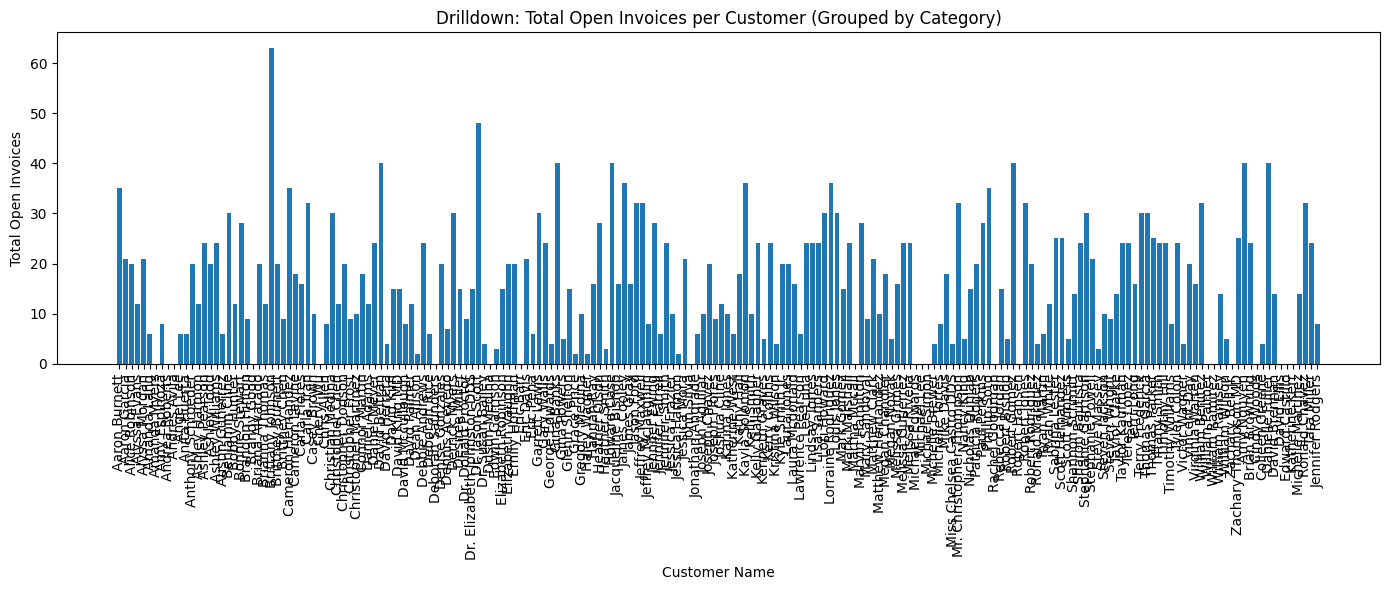

In [15]:
import matplotlib.pyplot as plt

# Convert Spark DF to pandas
drill_pd = drill_df.toPandas()

# Aggregate in case customers appear multiple times
cust_totals = (
    drill_pd.groupby(["category", "customer_name"])["total_open_invoices"]
    .sum()
    .reset_index()
)

# Plot
plt.figure(figsize=(14, 6))
plt.bar(cust_totals["customer_name"], cust_totals["total_open_invoices"])
plt.xticks(rotation=90)
plt.title("Drilldown: Total Open Invoices per Customer (Grouped by Category)")
plt.xlabel("Customer Name")
plt.ylabel("Total Open Invoices")
plt.tight_layout()
plt.show()

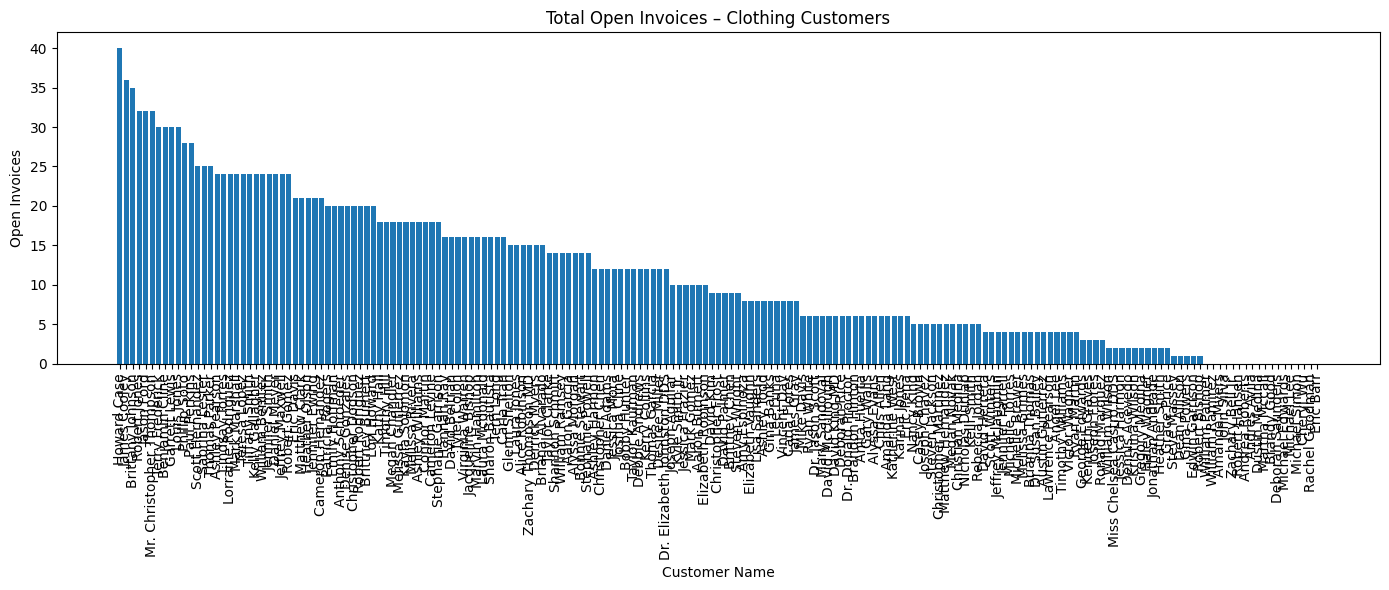

In [16]:
import matplotlib.pyplot as plt

# Convert Spark DF to pandas
drill_pd = drill_df.toPandas()

# Choose category to visualize
category_to_plot = "Clothing"

# Filter to that category only
filtered = drill_pd[drill_pd["category"] == category_to_plot]

# Aggregate open invoices per customer
cust_totals = (
    filtered.groupby("customer_name")["total_open_invoices"]
    .sum()
    .reset_index()
    .sort_values("total_open_invoices", ascending=False)
)

# Plot
plt.figure(figsize=(14, 6))
plt.bar(cust_totals["customer_name"], cust_totals["total_open_invoices"])
plt.xticks(rotation=90)
plt.title(f"Total Open Invoices – {category_to_plot} Customers")
plt.xlabel("Customer Name")
plt.ylabel("Open Invoices")
plt.tight_layout()
plt.show()

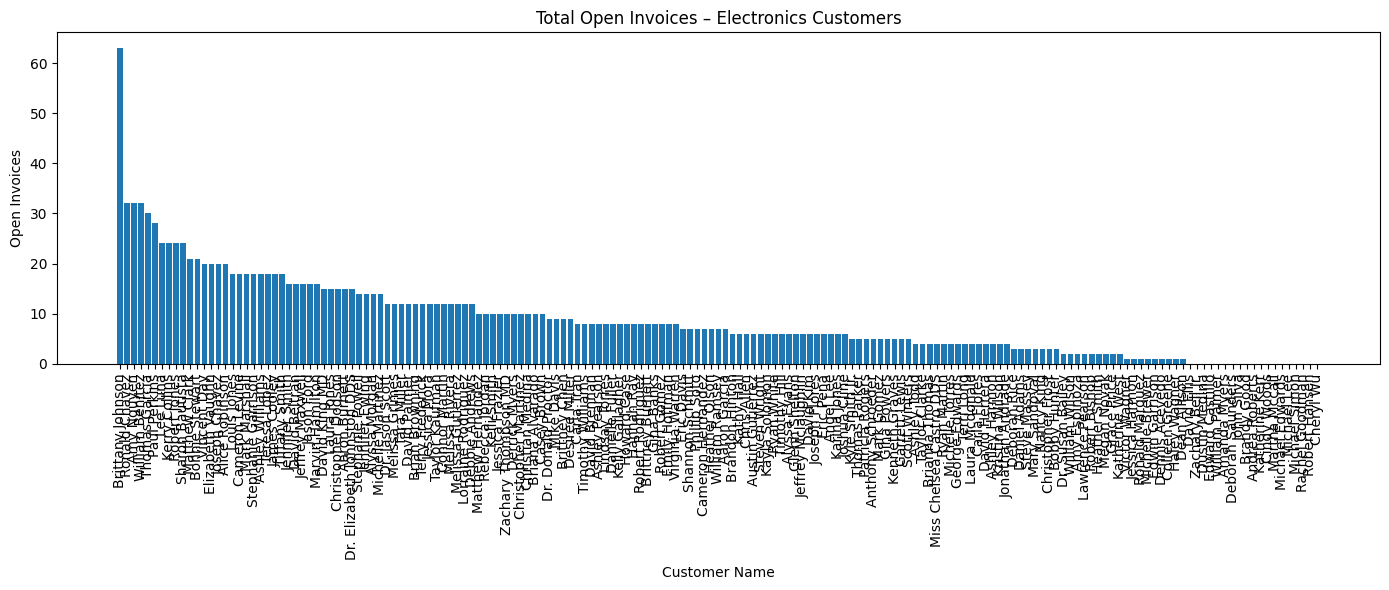

In [17]:
import matplotlib.pyplot as plt

# Convert Spark DF to pandas (skip if already done earlier)
drill_pd = drill_df.toPandas()

# Choose category to visualize
category_to_plot = "Electronics"

# Filter drilldown data for only this category
filtered = drill_pd[drill_pd["category"] == category_to_plot]

# Aggregate open invoices total per customer
cust_totals = (
    filtered.groupby("customer_name")["total_open_invoices"]
    .sum()
    .reset_index()
    .sort_values("total_open_invoices", ascending=False)
)

# Plot
plt.figure(figsize=(14, 6))
plt.bar(cust_totals["customer_name"], cust_totals["total_open_invoices"])
plt.xticks(rotation=90)
plt.title(f"Total Open Invoices – {category_to_plot} Customers")
plt.xlabel("Customer Name")
plt.ylabel("Open Invoices")
plt.tight_layout()
plt.show()

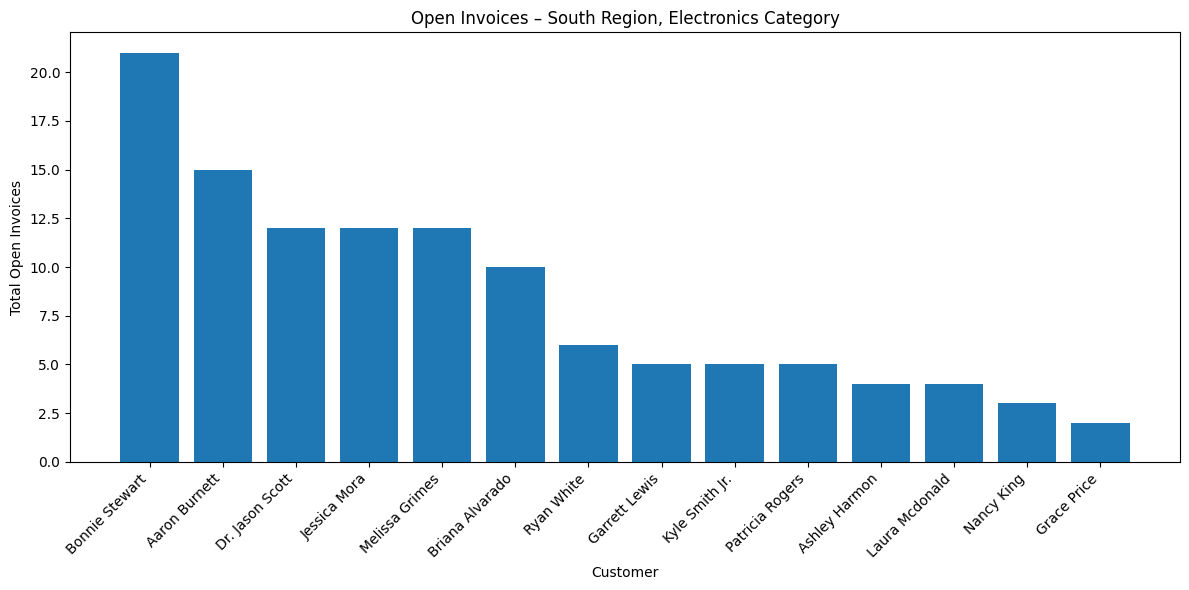

In [18]:
import matplotlib.pyplot as plt

# Convert Spark DF to pandas
drill_pd = drill_df.toPandas()

# Choose region + category to drill into
region_to_plot = "South"
category_to_plot = "Electronics"

# Filter the full drilldown dataframe
filtered = drill_pd[
    (drill_pd["region"] == region_to_plot) &
    (drill_pd["category"] == category_to_plot)
]

# Aggregate total open invoices for each customer
cust_totals = (
    filtered.groupby("customer_name")["total_open_invoices"]
    .sum()
    .reset_index()
    .sort_values("total_open_invoices", ascending=False)
)

# Plot
plt.figure(figsize=(12, 6))
plt.bar(cust_totals["customer_name"], cust_totals["total_open_invoices"])
plt.xticks(rotation=45, ha="right")
plt.title(f"Open Invoices – {region_to_plot} Region, {category_to_plot} Category")
plt.xlabel("Customer")
plt.ylabel("Total Open Invoices")
plt.tight_layout()
plt.show()

In [19]:
from pyspark.sql.functions import lower, initcap, col

customer_clean2 = (
    customer_clean
        .withColumn("region_clean", initcap(lower(col("region"))))
)

customer_clean2.show(10)

NameError: name 'customer_clean' is not defined

In [20]:
from pyspark.sql.functions import col, when

# Create a cleaned customer table (fix open_invoices_num issues)
customer_clean = (
    customer_df
        .withColumn(
            "open_invoices_num",
            when(col("open_invoices_num").rlike("^[0-9]+$"), col("open_invoices_num"))
            .otherwise(None)
        )
        .withColumn("open_invoices_num", col("open_invoices_num").cast("int"))
)

In [21]:
from pyspark.sql.functions import lower, initcap, col

customer_clean2 = (
    customer_clean
        .withColumn("region_clean", initcap(lower(col("region"))))
)

customer_clean2.show(10)

+-----------+----------------+-------+---------+-----------------+------------------+------------+
|customer_id|            name| region|join_date|open_invoices_num|retention_category|region_clean|
+-----------+----------------+-------+---------+-----------------+------------------+------------+
|       1000|    Robert Gomez|   West|  2/25/24|                8|         Recovered|        West|
|       1001|      John Silva|   East|  12/1/20|                0|         Recovered|        East|
|       1002|   Mark Marshall|Central|   8/8/20|                6|               New|     Central|
|       1003|   David Brennan|  North|  5/21/20|                2|         Recovered|       North|
|       1004|   Kerry Collins|  North|  9/12/23|                4|         Recovered|       North|
|       1005|    Jessica Mora|  South|   8/5/21|                3|            AtRisk|       South|
|       1006|      Hannah Ray|   West|   7/3/21|                8|         Recovered|        West|
|       10

In [22]:
from pyspark.sql.functions import regexp_replace

customer_clean2 = (
    customer_clean2
        .withColumn("region_clean", regexp_replace("region_clean", "-", " "))
)

In [23]:
dice_df = spark.sql("""
    SELECT 
        c.region_clean AS region,
        p.category,
        SUM(c.open_invoices_num) AS total_open_invoices
    FROM sale s
    JOIN customer_clean2 c 
        ON s.customer_id = c.customer_id
    JOIN product p 
        ON s.product_id = p.product_id
    GROUP BY 
        c.region_clean, p.category
    ORDER BY 
        c.region_clean, total_open_invoices DESC
""")

dice_df.show()

{"ts": "2025-11-29 16:37:41.542", "level": "ERROR", "logger": "SQLQueryContextLogger", "msg": "[TABLE_OR_VIEW_NOT_FOUND] The table or view `customer_clean2` cannot be found. Verify the spelling and correctness of the schema and catalog.\nIf you did not qualify the name with a schema, verify the current_schema() output, or qualify the name with the correct schema and catalog.\nTo tolerate the error on drop use DROP VIEW IF EXISTS or DROP TABLE IF EXISTS. SQLSTATE: 42P01", "context": {"errorClass": "TABLE_OR_VIEW_NOT_FOUND"}, "exception": {"class": "Py4JJavaError", "msg": "An error occurred while calling o29.sql.\n: org.apache.spark.sql.AnalysisException: [TABLE_OR_VIEW_NOT_FOUND] The table or view `customer_clean2` cannot be found. Verify the spelling and correctness of the schema and catalog.\nIf you did not qualify the name with a schema, verify the current_schema() output, or qualify the name with the correct schema and catalog.\nTo tolerate the error on drop use DROP VIEW IF EXISTS 

AnalysisException: [TABLE_OR_VIEW_NOT_FOUND] The table or view `customer_clean2` cannot be found. Verify the spelling and correctness of the schema and catalog.
If you did not qualify the name with a schema, verify the current_schema() output, or qualify the name with the correct schema and catalog.
To tolerate the error on drop use DROP VIEW IF EXISTS or DROP TABLE IF EXISTS. SQLSTATE: 42P01; line 7 pos 9;
'Sort ['c.region_clean ASC NULLS FIRST, 'total_open_invoices DESC NULLS LAST], true
+- 'Aggregate ['c.region_clean, 'p.category], ['c.region_clean AS region#255, 'p.category, 'SUM('c.open_invoices_num) AS total_open_invoices#256]
   +- 'Join Inner, ('s.product_id = 'p.product_id)
      :- 'Join Inner, ('s.customer_id = 'c.customer_id)
      :  :- SubqueryAlias s
      :  :  +- SubqueryAlias sale
      :  :     +- View (`sale`, [sale_id#0, customer_id#1, product_id#2, sale_amount_usd#3, sale_date#4, payment_type#5])
      :  :        +- Relation [sale_id#0,customer_id#1,product_id#2,sale_amount_usd#3,sale_date#4,payment_type#5] JDBCRelation(sale) [numPartitions=1]
      :  +- 'SubqueryAlias c
      :     +- 'UnresolvedRelation [customer_clean2], [], false
      +- SubqueryAlias p
         +- SubqueryAlias product
            +- View (`product`, [product_id#12, product_name#13, category#14, unit_price_usd#15, restock_days#16, supplier#17])
               +- Relation [product_id#12,product_name#13,category#14,unit_price_usd#15,restock_days#16,supplier#17] JDBCRelation(product) [numPartitions=1]


In [24]:
customer_clean2.createOrReplaceTempView("customer_clean2")

In [25]:
from pyspark.sql.functions import lower, initcap, col

customer_clean2 = (
    customer_df
        .withColumn("region_clean", initcap(lower(col("region"))))
)

customer_clean2.show(10)

# Register as SQL temp view
customer_clean2.createOrReplaceTempView("customer_clean2")

+-----------+----------------+-------+---------+-----------------+------------------+------------+
|customer_id|            name| region|join_date|open_invoices_num|retention_category|region_clean|
+-----------+----------------+-------+---------+-----------------+------------------+------------+
|       1000|    Robert Gomez|   West|  2/25/24|                8|         Recovered|        West|
|       1001|      John Silva|   East|  12/1/20|                0|         Recovered|        East|
|       1002|   Mark Marshall|Central|   8/8/20|                6|               New|     Central|
|       1003|   David Brennan|  North|  5/21/20|                2|         Recovered|       North|
|       1004|   Kerry Collins|  North|  9/12/23|                4|         Recovered|       North|
|       1005|    Jessica Mora|  South|   8/5/21|                3|            AtRisk|       South|
|       1006|      Hannah Ray|   West|   7/3/21|                8|         Recovered|        West|
|       10

In [26]:
dice_df = spark.sql("""
    SELECT 
        c.region_clean AS region,
        p.category,
        SUM(c.open_invoices_num) AS total_open_invoices
    FROM sale s
    JOIN customer_clean2 c 
        ON s.customer_id = c.customer_id
    JOIN product p 
        ON s.product_id = p.product_id
    GROUP BY 
        c.region_clean, p.category
    ORDER BY 
        c.region_clean, total_open_invoices DESC
""")

dice_df.show()

25/11/29 16:38:56 ERROR Executor: Exception in task 0.0 in stage 119.0 (TID 66)
org.apache.spark.SparkNumberFormatException: [CAST_INVALID_INPUT] The value 'A' of the type "STRING" cannot be cast to "DOUBLE" because it is malformed. Correct the value as per the syntax, or change its target type. Use `try_cast` to tolerate malformed input and return NULL instead. SQLSTATE: 22018
== SQL (line 5, position 9) ==
        SUM(c.open_invoices_num) AS total_open_invoices
        ^^^^^^^^^^^^^^^^^^^^^^^^

	at org.apache.spark.sql.errors.QueryExecutionErrors$.invalidInputInCastToNumberError(QueryExecutionErrors.scala:145)
	at org.apache.spark.sql.errors.QueryExecutionErrors.invalidInputInCastToNumberError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage4.hashAgg_doAggregate_sum_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage4.hashAgg_doConsume_0$(Unknown Sourc

NumberFormatException: [CAST_INVALID_INPUT] The value 'A' of the type "STRING" cannot be cast to "DOUBLE" because it is malformed. Correct the value as per the syntax, or change its target type. Use `try_cast` to tolerate malformed input and return NULL instead. SQLSTATE: 22018
== SQL (line 5, position 9) ==
        SUM(c.open_invoices_num) AS total_open_invoices
        ^^^^^^^^^^^^^^^^^^^^^^^^


In [27]:
from pyspark.sql.functions import col, lower, initcap

# 1. Cast invalid values to NULL using try_cast
customer_clean = customer_df.withColumn(
    "open_invoices_num",
    col("open_invoices_num").cast("double")
)

# 2. Drop rows where cast failed
customer_clean = customer_clean.dropna(subset=["open_invoices_num"])

# 3. Clean region names (fix EAST/east/East etc.)
customer_clean = customer_clean.withColumn(
    "region_clean", 
    initcap(lower(col("region")))
)

customer_clean.show(20)

# 4. Register clean table as SQL view
customer_clean.createOrReplaceTempView("customer_clean")

+-----------+----------------+----------+---------+-----------------+------------------+------------+
|customer_id|            name|    region|join_date|open_invoices_num|retention_category|region_clean|
+-----------+----------------+----------+---------+-----------------+------------------+------------+
|       1000|    Robert Gomez|      West|  2/25/24|              8.0|         Recovered|        West|
|       1001|      John Silva|      East|  12/1/20|              0.0|         Recovered|        East|
|       1002|   Mark Marshall|   Central|   8/8/20|              6.0|               New|     Central|
|       1003|   David Brennan|     North|  5/21/20|              2.0|         Recovered|       North|
|       1004|   Kerry Collins|     North|  9/12/23|              4.0|         Recovered|       North|
|       1005|    Jessica Mora|     South|   8/5/21|              3.0|            AtRisk|       South|
|       1006|      Hannah Ray|      West|   7/3/21|              8.0|         Reco

In [28]:
dice_df = spark.sql("""
    SELECT 
        c.region_clean AS region,
        p.category,
        SUM(c.open_invoices_num) AS total_open_invoices
    FROM sale s
    JOIN customer_clean c 
        ON s.customer_id = c.customer_id
    JOIN product p 
        ON s.product_id = p.product_id
    GROUP BY 
        c.region_clean, p.category
    ORDER BY 
        c.region_clean, total_open_invoices DESC
""")

dice_df.show()

25/11/29 16:39:43 WARN DiskBlockObjectWriter: Error deleting /private/var/folders/fq/7tqkkn2x1xl0btcnxpvjbk500000gn/T/blockmgr-06f3132f-ac5d-4ea5-a581-6cb20227e015/2d/temp_shuffle_50f37703-d2d1-48b6-a15b-a1fb7dfab52b
25/11/29 16:39:43 WARN DiskBlockObjectWriter: Error deleting /private/var/folders/fq/7tqkkn2x1xl0btcnxpvjbk500000gn/T/blockmgr-06f3132f-ac5d-4ea5-a581-6cb20227e015/2f/temp_shuffle_9cf4233c-62c6-4457-a82c-d2ccb62ee714
25/11/29 16:39:43 WARN DiskBlockObjectWriter: Error deleting /private/var/folders/fq/7tqkkn2x1xl0btcnxpvjbk500000gn/T/blockmgr-06f3132f-ac5d-4ea5-a581-6cb20227e015/0b/temp_shuffle_5d9aa462-9903-46df-ac15-35c30bbd30ff
25/11/29 16:39:43 WARN DiskBlockObjectWriter: Error deleting /private/var/folders/fq/7tqkkn2x1xl0btcnxpvjbk500000gn/T/blockmgr-06f3132f-ac5d-4ea5-a581-6cb20227e015/30/temp_shuffle_37d3736e-df93-4b5b-b683-27ab81c31bb3
25/11/29 16:39:43 WARN DiskBlockObjectWriter: Error deleting /private/var/folders/fq/7tqkkn2x1xl0btcnxpvjbk500000gn/T/blockmgr-06f31

NumberFormatException: [CAST_INVALID_INPUT] The value 'Loyal' of the type "STRING" cannot be cast to "DOUBLE" because it is malformed. Correct the value as per the syntax, or change its target type. Use `try_cast` to tolerate malformed input and return NULL instead. SQLSTATE: 22018
== DataFrame ==
"cast" was called from
line 6 in cell [27]


In [29]:
col("open_invoices_num").cast("double")

Column<'CAST(open_invoices_num AS DOUBLE)'>

In [30]:
from pyspark.sql.functions import col, lower, initcap, expr

# 1. Clean open_invoices_num using try_cast
customer_clean = (
    customer_df
        .withColumn(
            "open_invoices_num",
            expr("try_cast(open_invoices_num AS double)")
        )
        .dropna(subset=["open_invoices_num"])  # remove invalid rows
)

# 2. Standardize region names
customer_clean = customer_clean.withColumn(
    "region_clean",
    initcap(lower(col("region")))
)

customer_clean.show(20)

# 3. Register the cleaned table
customer_clean.createOrReplaceTempView("customer_clean")

+-----------+----------------+----------+---------+-----------------+------------------+------------+
|customer_id|            name|    region|join_date|open_invoices_num|retention_category|region_clean|
+-----------+----------------+----------+---------+-----------------+------------------+------------+
|       1000|    Robert Gomez|      West|  2/25/24|              8.0|         Recovered|        West|
|       1001|      John Silva|      East|  12/1/20|              0.0|         Recovered|        East|
|       1002|   Mark Marshall|   Central|   8/8/20|              6.0|               New|     Central|
|       1003|   David Brennan|     North|  5/21/20|              2.0|         Recovered|       North|
|       1004|   Kerry Collins|     North|  9/12/23|              4.0|         Recovered|       North|
|       1005|    Jessica Mora|     South|   8/5/21|              3.0|            AtRisk|       South|
|       1006|      Hannah Ray|      West|   7/3/21|              8.0|         Reco

In [31]:
dice_df = spark.sql("""
    SELECT 
        c.region_clean AS region,
        p.category,
        SUM(c.open_invoices_num) AS total_open_invoices
    FROM sale s
    JOIN customer_clean c 
        ON s.customer_id = c.customer_id
    JOIN product p 
        ON s.product_id = p.product_id
    GROUP BY 
        c.region_clean, p.category
    ORDER BY 
        c.region_clean, total_open_invoices DESC
""")

dice_df.show()

+----------+-----------+-------------------+
|    region|   category|total_open_invoices|
+----------+-----------+-------------------+
|   Central|   Clothing|              224.0|
|   Central|     Office|              219.0|
|   Central|       Home|              214.0|
|   Central|Electronics|              187.0|
|      East|       Home|              796.0|
|      East|   Clothing|              730.0|
|      East|Electronics|              576.0|
|      East|     Office|              554.0|
|     North|       Home|              422.0|
|     North|   Clothing|              336.0|
|     North|     Office|              314.0|
|     North|Electronics|              290.0|
|     South|       Home|              298.0|
|     South|   Clothing|              296.0|
|     South|     Office|              208.0|
|     South|Electronics|              116.0|
|South-west|     Office|              176.0|
|South-west|       Home|              171.0|
|South-west|   Clothing|              138.0|
|South-wes

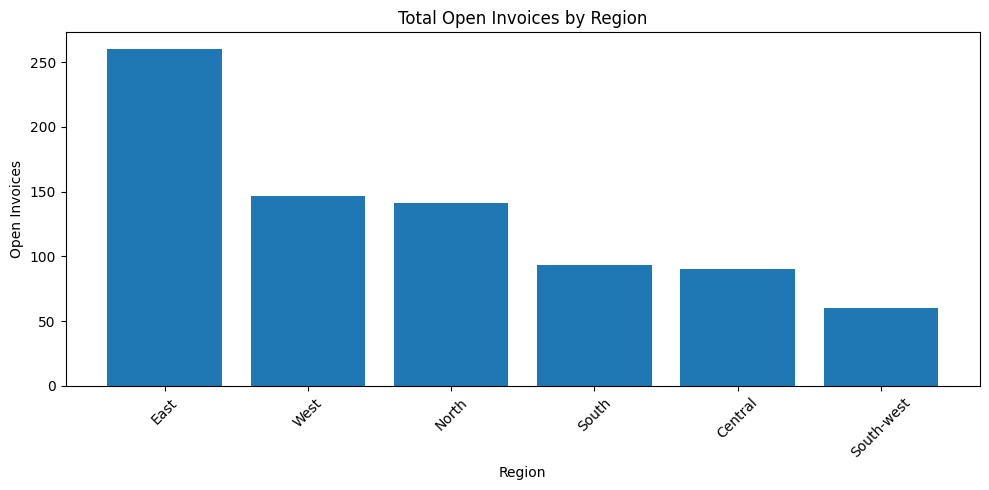

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Pull data from Spark
region_df = spark.sql("""
    SELECT 
        region_clean AS region,
        SUM(open_invoices_num) AS total_open_invoices
    FROM customer_clean
    GROUP BY region_clean
    ORDER BY total_open_invoices DESC
""").toPandas()

# Plot
plt.figure(figsize=(10, 5))
plt.bar(region_df["region"], region_df["total_open_invoices"])
plt.title("Total Open Invoices by Region")
plt.xlabel("Region")
plt.ylabel("Open Invoices")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

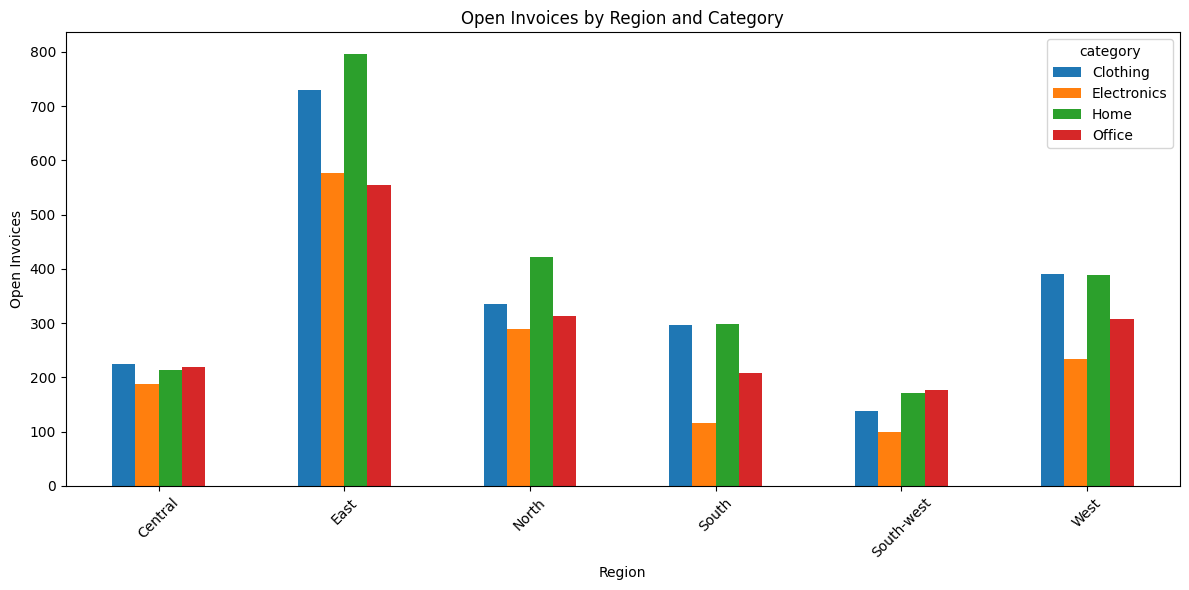

In [33]:
# Spark SQL pivot
dice_df = spark.sql("""
    SELECT 
        region_clean AS region,
        category,
        SUM(open_invoices_num) AS total_open_invoices
    FROM sale s
    JOIN customer_clean c ON s.customer_id = c.customer_id
    JOIN product p ON s.product_id = p.product_id
    GROUP BY region_clean, category
""").toPandas()

pivot_df = dice_df.pivot(index="region", columns="category", values="total_open_invoices").fillna(0)

pivot_df.plot(kind="bar", figsize=(12,6))
plt.title("Open Invoices by Region and Category")
plt.xlabel("Region")
plt.ylabel("Open Invoices")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()